In [2]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import chain
df = pd.read_csv('../res/input0130.csv')

In [3]:
scaler = StandardScaler()
starter = range(240,len(df)-1000,10)
all_results = []
all_evas = []
y_pred_clf = []
all_x_train = []
all_x_test = []
all_y_train = []
all_y_test = []
for train_begin in starter:
    train_end = train_begin + 750
    test_end = train_end + 250
    train_set = df[{'log_r','label'}][train_begin:train_end].reset_index()
    x_train, y_train = [], []
    x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_train_set)):
        x_train.append(x_train_set[i-240:i])
        y_train.append(train_set['label'][i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
    
    # model = lstm_model()
    # model.fit(x_train,y_train,epochs=100,callbacks=[EarlyStopping(monitor='loss',patience=10)])

    x_test, y_test = [], []
    test_set = df[{'log_r','label'}][train_end-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    all_x_train.append(x_train)
    all_y_train.append(y_train)
    all_x_test.append(x_test)
    all_y_test.append(y_test)

    # all_results.append(model.predict(x_test))
    # all_evas.append(model.evaluate(x_test, y_test))
    # y_pred_clf.append(model.predict_classes(x_test))

In [4]:
from tqdm import tqdm
from keras.models import load_model, Model
from sa import *
from utils import *

Using TensorFlow backend.


In [5]:
model = load_model('lstm_r_1c.h5')
default_upper_bound = 2000
default_n_bucket = 1000
default_n_classes = 2
class Args(): #创建一个类
    def __init__(self): #定义初始化信息。
        self.is_classification = True
        self.save_path = './tmp/'
        self.d = 'lstm_r'
        self.num_classes = 2
        self.lsa = True
        self.dsa = True
        self.target = 'none'
        self.batch_size = 128
        self.var_threshold = 1e-5
        self.upper_bound = 2000
        self.n_bucket = 1000
        self.is_classification = True
args = Args()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________


In [6]:
layer_names = ['activation_1']

In [7]:
num=0
test_auc = []
test_cov = []
test_lsa = fetch_lsa(model, x_train, x_test, "test", layer_names, args)
for x_test in all_x_test:
    num=num+1
    target_lsa = fetch_lsa(model, x_train, x_test, str(num), layer_names, args)
    # target_lsa = fetch_lsa(model, x_train, x_target, args.target, layer_names, args)
    target_cov = get_sc(
        np.amin(target_lsa), default_upper_bound, default_n_bucket, target_lsa
    )

    auc = compute_roc_auc(test_lsa, target_lsa, 10)
    test_auc.append(auc)
    test_cov.append(target_cov)
    print(infog("ROC-AUC: " + str(auc * 100)))

    print(infog("LSA coverage: " + str(target_cov)))
    if num >= 164:
        break

18.91it/s]ROC-AUC: 82.99479166666667
LSA coverage: 8.4
Found saved train ATs, skip serving
Found saved 104 ATs, skip serving
The number of removed columns: 0
[104] Fetching LSA

100%|██████████| 250/250 [00:00<00:00, 3133.30it/s]ROC-AUC: 81.57899305555554
LSA coverage: 7.000000000000001
Found saved train ATs, skip serving
Found saved 105 ATs, skip serving
The number of removed columns: 0
[105] Fetching LSA

100%|██████████| 250/250 [00:00<00:00, 3528.85it/s]ROC-AUC: 89.8732638888889
LSA coverage: 7.1
Found saved train ATs, skip serving
Found saved 106 ATs, skip serving
The number of removed columns: 0
[106] Fetching LSA

100%|██████████| 250/250 [00:00<00:00, 2984.12it/s]ROC-AUC: 90.05468750000001
LSA coverage: 5.6000000000000005
Found saved train ATs, skip serving
Found saved 107 ATs, skip serving
The number of removed columns: 0
[107] Fetching LSA

100%|██████████| 250/250 [00:00<00:00, 3133.41it/s]ROC-AUC: 92.46180555555556
LSA coverage: 5.4
Found saved train ATs, skip serving
Found

In [12]:
lsa_result = pd.DataFrame(np.array([test_cov,test_auc]).T,columns=['cov','auc'])
lsa_result

,cov,auc
0,14.1,0.610417
1,13.3,0.574583
2,12.9,0.557344
3,12.1,0.527292
4,11.9,0.526267
...,...,...
159,4.9,0.182031
160,4.7,0.174063
161,4.5,0.178802
162,4.1,0.817049


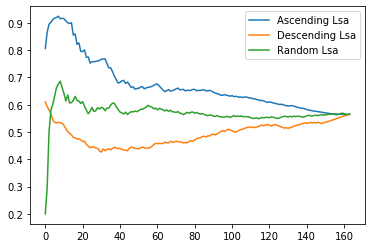

In [33]:
import matplotlib.pyplot as plt
lsa_result = pd.DataFrame(np.array([test_cov,test_auc]).T,columns=['cov','auc'])
lsa_down = lsa_result.sort_values('cov',ascending=False)
lsa_up = lsa_result.sort_values('cov')
x = range(0,164,1)
plt.plot(x,lsa_up['auc'].rolling(164, min_periods=1).mean(),label='Ascending Lsa')
plt.plot(x,lsa_down['auc'].rolling(164, min_periods=1).mean(),label='Descending Lsa')
plt.plot(x,lsa_result.sample(frac=1)['auc'].rolling(164, min_periods=1).mean(),label='Random Lsa')
plt.legend()

In [25]:
num=0
dsa_auc = []
dsa_cov = []
test_dsa = fetch_dsa(model, x_train, x_test, "test", layer_names, args)
for x_test in all_x_test:
    num=num+1
    target_dsa = fetch_dsa(model, x_train, x_test, str(num), layer_names, args)
    # target_dsa = fetch_dsa(model, x_train, x_target, args.target, layer_names, args)
    target_cov = get_sc(
        np.amin(target_dsa), default_upper_bound, default_n_bucket, target_dsa
    )

    auc = compute_roc_auc(test_dsa, target_dsa, 10)
    dsa_auc.append(auc)
    dsa_cov.append(target_cov)
    print(infog("ROC-AUC: " + str(auc * 100)))

    print(infog("dsa coverage: " + str(target_cov)))
    if num >= 164:
        break

.6935763888889
dsa coverage: 0.3
Found saved train ATs, skip serving
Found saved 78 ATs, skip serving
[78] Fetching DSA

100%|██████████| 250/250 [00:00<00:00, 4476.37it/s]ROC-AUC: 38.49826388888889
dsa coverage: 0.3
Found saved train ATs, skip serving
Found saved 79 ATs, skip serving
[79] Fetching DSA

100%|██████████| 250/250 [00:00<00:00, 4820.60it/s]ROC-AUC: 35.333333333333336
dsa coverage: 0.3
Found saved train ATs, skip serving
Found saved 80 ATs, skip serving
[80] Fetching DSA

100%|██████████| 250/250 [00:00<00:00, 5113.88it/s]ROC-AUC: 33.75
dsa coverage: 0.2
Found saved train ATs, skip serving
Found saved 81 ATs, skip serving
[81] Fetching DSA

100%|██████████| 250/250 [00:00<00:00, 4321.94it/s]ROC-AUC: 32.885416666666664
dsa coverage: 0.2
Found saved train ATs, skip serving
Found saved 82 ATs, skip serving
[82] Fetching DSA

100%|██████████| 250/250 [00:00<00:00, 4557.74it/s]ROC-AUC: 33.26041666666667
dsa coverage: 0.2
Found saved train ATs, skip serving
Found saved 83 ATs, s

In [34]:
dsa_result

,cov,auc
0,0.3,0.616649
1,0.3,0.596163
2,0.3,0.569931
3,0.3,0.551528
4,0.3,0.543003
...,...,...
159,0.2,0.337917
160,0.2,0.333003
161,0.2,0.331128
162,0.2,0.333819


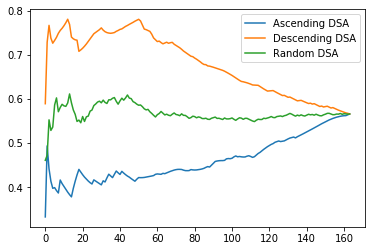

In [31]:
dsa_result = pd.DataFrame(np.array([dsa_cov,dsa_auc]).T,columns=['cov','auc'])
dsa_down = dsa_result.sort_values('cov',ascending=False)
dsa_up = dsa_result.sort_values('cov')
x = range(0,164,1)
plt.plot(x,dsa_up['auc'].rolling(164, min_periods=1).mean(),label='Ascending DSA')
plt.plot(x,dsa_down['auc'].rolling(164, min_periods=1).mean(),label='Descending DSA')
plt.plot(x,dsa_result.sample(frac=1)['auc'].rolling(164, min_periods=1).mean(),label='Random DSA')
plt.legend()